# Architektur Neuronales Netz, Output x_H2 und x_NH3

In [1]:
# aNN Architektur

# Importe / Bibliotheken
import torch
from torch import nn
from torch.nn.functional import normalize as norm
from torch import log10
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR, MultiStepLR, ReduceLROnPlateau
from sklearn.metrics import r2_score as r2
from sklearn.metrics import max_error
# from sklearn.metrics import mean_squared_error as MSE
# from sklearn.metrics import mean_absolute_error as MAE
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

#### Default Datentyp

In [2]:
torch.set_default_dtype(torch.float64)

#### Erzeugnung des Moduls

In [3]:
class NeuralNetwork(nn.Module):
    
    #Initalisierung der Netzwerk layers
    def __init__(self, input_size, hidden1_size, hidden2_size, hidden3_size, output_size):
    
        super().__init__() #Referenz zur Base Class (nn.Module)
        #Kaskade der Layer
        self.linear_afunc_stack = nn.Sequential(
            nn.BatchNorm1d(input_size), # Normalisierung, damit Inputdaten gleiche Größenordnung haben
            nn.Linear(input_size, hidden1_size), #Lineare Transformation mit gespeicherten weights und biases
            nn.Tanh(), #Nicht lineare Aktivierungsfunktion um komplexe nichtlineare Zusammenhänge abzubilden
            #nn.SELU(),
            nn.Linear(hidden1_size, hidden2_size),
            nn.Tanh(),
            #nn.SELU(),
            nn.Linear(hidden2_size, hidden3_size),
            nn.Tanh(),
            #nn.SELU(),
            nn.Linear(hidden3_size, output_size),
        )

    #Implementierung der Operationen auf Input Daten
    def forward(self, x):
        out = self.linear_afunc_stack(x)
        return out

#### Ausgabe Modul

In [4]:
model = NeuralNetwork(5, 200, 200, 200, 2)
print(model)

NeuralNetwork(
  (linear_afunc_stack): Sequential(
    (0): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=5, out_features=200, bias=True)
    (2): Tanh()
    (3): Linear(in_features=200, out_features=200, bias=True)
    (4): Tanh()
    (5): Linear(in_features=200, out_features=200, bias=True)
    (6): Tanh()
    (7): Linear(in_features=200, out_features=2, bias=True)
  )
)


#### DataLoader

In [5]:
batch_size = 64 #Zahl der Datenpaare die vor einem erneuten Update der Parameter ins Netzt gegeben werden
eq_data_file = Path.cwd() / 'data' / 'eq_dataset_x.npz' #Import der GGW Daten

res = np.load(eq_data_file)

# Bei Speicherung wurden Daten als T, p, x_0 und xi gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Outputs x[H2,N2,NH3]
# Umwandlen der np.arrays in torch.tensors zur besseren Arbeit mit PyTorch
T = torch.tensor(res['T'])
p = torch.tensor(res['p'])
x_0 = torch.tensor(res['x_0'])
x = torch.tensor(res['x'])

#Anpassen der Daten auf gleiche Größenordnung
#T = log10(T)
# T = T / 850
# p = p / 1000


# print(T.dtype)
# print(xi.dtype)

x_input = torch.stack((T, p ,x_0[:,0],x_0[:,1],x_0[:,2]),1)
y_output = torch.stack((x[:,0], x[:,2]), 1) # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
#print(x_input.size())
# print(xi.size())

# #Normalisieren der Tensoren
# x_input = norm(x_input, p=1, dim = 1)
# y_output = norm(y_output, p=1, dim = 0)

# Tensoren zu einem großen Set gruppieren
dataset = TensorDataset(x_input, y_output)

# for x,y in dataset:
#     print(x)
#     print(y)
    
# Split in Trainings und Test Set
train_dataset, test_dataset = random_split(dataset, 
                                           [int(0.8*len(dataset)), int(0.2*len(dataset))], # splitting 80/20
                                           generator = torch.Generator().manual_seed(42)) # Festlegung seed zur Reproduktivität

# Erzeugen der DataLoader zur Arbeit mit Daten
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True) # shuffle batches zur Reduzierung von overfitting
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)


#### Generierung Netzwerk, Festlegung von loss Funktion und Optimizer

In [6]:
# Erzeugung aNN
net = NeuralNetwork(5, 200, 200, 200, 2)

# Loss Funktion; gibt Fehler an
#loss_fn = nn.MSELoss()
loss_fn = nn.L1Loss()

#Definition custom loss Funktion, MRE
def MRELoss(outputs, targets):
    
    loss = torch.mean(abs((outputs - targets) / targets))
    
    return loss
    

#Optimizer
learning_rate = 1e-2
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)
#scheduler = StepLR(optimizer, step_size = 30, gamma = 0.1)
#scheduler = MultiStepLR(optimizer, milestones=[30, 70, 100], gamma = 0.1)
scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 10, threshold = 1e-4)

In [7]:
# learning_rate = 1e-6
# optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate, )

#### Funktion zur Bestimmung der Genauigkeit

In [8]:
def check_accuracy(loader, net):
    
    loss = 0
    MRE = 0
    train_correct = 0
    train_total = len(loader.dataset)
    num_batches = len(loader) 
    #train_total = 0
    
    net.eval() # Put network in evaluation mode
    
    if loader == train_dataloader:
        dataset = "Train"
    else:
        dataset = "Test"
    
    with torch.no_grad():
        for X, y in loader:
            pred = net(X)
           
            #loss += MRELoss(pred, y).item()
            loss += loss_fn(pred, y) # Calculate the loss
            MRE += MRELoss(pred, y)

            # Record the correct predictions for training data
            #_, predictions = torch.max(pred.data, 1)
            for i in range(len(pred)):
                if (pred[i,0] - y[i,0] and pred[i,1] - y[i,1]) <= 0.01:
                    train_correct += 1
            #train_correct += (abs(pred.argmax(1) - y) <= 0.01).sum().item()
            #train_correct += (abs(predictions - y.data) <= 0.01).sum()
            #train_total += predictions.size(0)
            
        # Genauigkeit berechnen
        acc = float(train_correct) / float(train_total) * 100
        acc = round(acc, 2)
        
        loss /= num_batches
        MRE /= num_batches
        print(f"{dataset} Error: \n Accuracy: {acc}%, Avg loss: {loss:>8f}, MRE: {MRE:>8f} \n")

    net.train()
    
    return acc, loss, MRE

#### Training

In [9]:
num_epochs = 200 #Iterationen über Datenset

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
train_MRE = []
test_MRE = []

#Optimierungsloop
for epoch in range(num_epochs):
#     train_correct = 0
#     train_total = 0
        
    for batch, (X,y) in enumerate(train_dataloader):
        
#         print(X.shape)
#         print(X.dtype)
        
        net.train() #Trainingmodus
        
        # forward
        pred = net(X)  # Do the forward pass
        loss = loss_fn(pred, y) # Calculate the loss
        #loss = MRELoss(pred, y)
        
        # backward
        optimizer.zero_grad() # Clear off the gradients from any past operation
        loss.backward()       # Calculate the gradients with help of back propagation, updating weights and biases
        
        # adam step gradient descent
        optimizer.step()      # Ask the optimizer to adjust the parameters based on the gradients  

        print ('Epoch %d/%d, Iteration %d/%d, Loss: %.4f' 
               %(epoch+1, num_epochs, batch+1, len(train_dataset)//batch_size, loss.item()))
        
    
    #scheduler.step() # Reduzieren Learning Rate (falls step size erreicht)
    net.eval() # Put the network into evaluation mode
    
    # Book keeping    
    # What was our train accuracy?
    tr_acc, tr_loss, tr_MRE = check_accuracy(train_dataloader, net)
    
    #Record loss and accuracy
    train_accuracy.append(tr_acc)
    train_loss.append(tr_loss)
    train_MRE.append(tr_MRE)
    
    scheduler.step(tr_loss) # LR scheduler step für reduceonPlateau
    
    # How did we do on the test set (the unseen set)
    # Record the correct predictions for test data
    t_acc, t_loss, t_MRE = check_accuracy(test_dataloader, net)
    test_accuracy.append(t_acc)
    test_loss.append(t_loss)
    test_MRE.append(t_MRE)

Epoch 1/200, Iteration 1/12, Loss: 0.3352
Epoch 1/200, Iteration 2/12, Loss: 1.3720
Epoch 1/200, Iteration 3/12, Loss: 2.2480
Epoch 1/200, Iteration 4/12, Loss: 1.2950
Epoch 1/200, Iteration 5/12, Loss: 0.5443
Epoch 1/200, Iteration 6/12, Loss: 0.7579
Epoch 1/200, Iteration 7/12, Loss: 0.8827
Epoch 1/200, Iteration 8/12, Loss: 0.8465
Epoch 1/200, Iteration 9/12, Loss: 0.6048
Epoch 1/200, Iteration 10/12, Loss: 0.3978
Epoch 1/200, Iteration 11/12, Loss: 0.5003
Epoch 1/200, Iteration 12/12, Loss: 0.5025
Epoch 1/200, Iteration 13/12, Loss: 0.4408
Train Error: 
 Accuracy: 0.25%, Avg loss: 0.318687, MRE: 2.926593 

Test Error: 
 Accuracy: 1.0%, Avg loss: 0.325555, MRE: 2.672385 

Epoch 2/200, Iteration 1/12, Loss: 0.3412
Epoch 2/200, Iteration 2/12, Loss: 0.1734
Epoch 2/200, Iteration 3/12, Loss: 0.2078
Epoch 2/200, Iteration 4/12, Loss: 0.2736
Epoch 2/200, Iteration 5/12, Loss: 0.2203
Epoch 2/200, Iteration 6/12, Loss: 0.1679
Epoch 2/200, Iteration 7/12, Loss: 0.1424
Epoch 2/200, Iteration

Epoch 13/200, Iteration 8/12, Loss: 0.0285
Epoch 13/200, Iteration 9/12, Loss: 0.0232
Epoch 13/200, Iteration 10/12, Loss: 0.0591
Epoch 13/200, Iteration 11/12, Loss: 0.0512
Epoch 13/200, Iteration 12/12, Loss: 0.0492
Epoch 13/200, Iteration 13/12, Loss: 0.0482
Train Error: 
 Accuracy: 87.25%, Avg loss: 0.045585, MRE: 0.269287 

Test Error: 
 Accuracy: 88.0%, Avg loss: 0.044968, MRE: 0.266483 

Epoch 14/200, Iteration 1/12, Loss: 0.0498
Epoch 14/200, Iteration 2/12, Loss: 0.0425
Epoch 14/200, Iteration 3/12, Loss: 0.0452
Epoch 14/200, Iteration 4/12, Loss: 0.0635
Epoch 14/200, Iteration 5/12, Loss: 0.0467
Epoch 14/200, Iteration 6/12, Loss: 0.0714
Epoch 14/200, Iteration 7/12, Loss: 0.0370
Epoch 14/200, Iteration 8/12, Loss: 0.0272
Epoch 14/200, Iteration 9/12, Loss: 0.0573
Epoch 14/200, Iteration 10/12, Loss: 0.0858
Epoch 14/200, Iteration 11/12, Loss: 0.0787
Epoch 14/200, Iteration 12/12, Loss: 0.0475
Epoch 14/200, Iteration 13/12, Loss: 0.0605
Train Error: 
 Accuracy: 94.5%, Avg los

Train Error: 
 Accuracy: 59.25%, Avg loss: 0.030250, MRE: 0.229941 

Test Error: 
 Accuracy: 57.0%, Avg loss: 0.030777, MRE: 0.201005 

Epoch 26/200, Iteration 1/12, Loss: 0.0334
Epoch 26/200, Iteration 2/12, Loss: 0.0441
Epoch 26/200, Iteration 3/12, Loss: 0.0306
Epoch 26/200, Iteration 4/12, Loss: 0.0296
Epoch 26/200, Iteration 5/12, Loss: 0.0755
Epoch 26/200, Iteration 6/12, Loss: 0.0578
Epoch 26/200, Iteration 7/12, Loss: 0.0377
Epoch 26/200, Iteration 8/12, Loss: 0.0467
Epoch 26/200, Iteration 9/12, Loss: 0.0361
Epoch 26/200, Iteration 10/12, Loss: 0.0308
Epoch 26/200, Iteration 11/12, Loss: 0.0572
Epoch 26/200, Iteration 12/12, Loss: 0.0317
Epoch 26/200, Iteration 13/12, Loss: 0.1021
Train Error: 
 Accuracy: 70.88%, Avg loss: 0.056168, MRE: 0.267607 

Test Error: 
 Accuracy: 75.5%, Avg loss: 0.053697, MRE: 0.237834 

Epoch 27/200, Iteration 1/12, Loss: 0.0596
Epoch 27/200, Iteration 2/12, Loss: 0.0348
Epoch 27/200, Iteration 3/12, Loss: 0.0368
Epoch 27/200, Iteration 4/12, Loss: 

Train Error: 
 Accuracy: 33.12%, Avg loss: 0.018578, MRE: 0.134269 

Test Error: 
 Accuracy: 34.5%, Avg loss: 0.018817, MRE: 0.129330 

Epoch 39/200, Iteration 1/12, Loss: 0.0149
Epoch 39/200, Iteration 2/12, Loss: 0.0302
Epoch 39/200, Iteration 3/12, Loss: 0.0195
Epoch 39/200, Iteration 4/12, Loss: 0.0188
Epoch 39/200, Iteration 5/12, Loss: 0.0236
Epoch 39/200, Iteration 6/12, Loss: 0.0143
Epoch 39/200, Iteration 7/12, Loss: 0.0155
Epoch 39/200, Iteration 8/12, Loss: 0.0173
Epoch 39/200, Iteration 9/12, Loss: 0.0098
Epoch 39/200, Iteration 10/12, Loss: 0.0157
Epoch 39/200, Iteration 11/12, Loss: 0.0356
Epoch 39/200, Iteration 12/12, Loss: 0.0252
Epoch 39/200, Iteration 13/12, Loss: 0.0270
Train Error: 
 Accuracy: 72.5%, Avg loss: 0.019849, MRE: 0.114992 

Test Error: 
 Accuracy: 74.5%, Avg loss: 0.020864, MRE: 0.115794 

Epoch 40/200, Iteration 1/12, Loss: 0.0197
Epoch 40/200, Iteration 2/12, Loss: 0.0320
Epoch 40/200, Iteration 3/12, Loss: 0.0373
Epoch 40/200, Iteration 4/12, Loss: 0

Train Error: 
 Accuracy: 94.5%, Avg loss: 0.007299, MRE: 0.045013 

Test Error: 
 Accuracy: 93.0%, Avg loss: 0.008274, MRE: 0.047743 

Epoch 51/200, Iteration 1/12, Loss: 0.0337
Epoch 51/200, Iteration 2/12, Loss: 0.0162
Epoch 51/200, Iteration 3/12, Loss: 0.0074
Epoch 51/200, Iteration 4/12, Loss: 0.0136
Epoch 51/200, Iteration 5/12, Loss: 0.0159
Epoch 51/200, Iteration 6/12, Loss: 0.0094
Epoch 51/200, Iteration 7/12, Loss: 0.0183
Epoch 51/200, Iteration 8/12, Loss: 0.0103
Epoch 51/200, Iteration 9/12, Loss: 0.0224
Epoch 51/200, Iteration 10/12, Loss: 0.0235
Epoch 51/200, Iteration 11/12, Loss: 0.0115
Epoch 51/200, Iteration 12/12, Loss: 0.0124
Epoch 51/200, Iteration 13/12, Loss: 0.0214
Train Error: 
 Accuracy: 95.12%, Avg loss: 0.006793, MRE: 0.047524 

Test Error: 
 Accuracy: 92.0%, Avg loss: 0.007354, MRE: 0.043071 

Epoch 52/200, Iteration 1/12, Loss: 0.0081
Epoch 52/200, Iteration 2/12, Loss: 0.0187
Epoch 52/200, Iteration 3/12, Loss: 0.0076
Epoch 52/200, Iteration 4/12, Loss: 0

Test Error: 
 Accuracy: 93.5%, Avg loss: 0.007374, MRE: 0.042700 

Epoch 63/200, Iteration 1/12, Loss: 0.0221
Epoch 63/200, Iteration 2/12, Loss: 0.0190
Epoch 63/200, Iteration 3/12, Loss: 0.0156
Epoch 63/200, Iteration 4/12, Loss: 0.0084
Epoch 63/200, Iteration 5/12, Loss: 0.0162
Epoch 63/200, Iteration 6/12, Loss: 0.0313
Epoch 63/200, Iteration 7/12, Loss: 0.0211
Epoch 63/200, Iteration 8/12, Loss: 0.0086
Epoch 63/200, Iteration 9/12, Loss: 0.0330
Epoch 63/200, Iteration 10/12, Loss: 0.0170
Epoch 63/200, Iteration 11/12, Loss: 0.0116
Epoch 63/200, Iteration 12/12, Loss: 0.0109
Epoch 63/200, Iteration 13/12, Loss: 0.0284
Train Error: 
 Accuracy: 96.75%, Avg loss: 0.007321, MRE: 0.038238 

Test Error: 
 Accuracy: 95.0%, Avg loss: 0.007677, MRE: 0.038527 

Epoch 64/200, Iteration 1/12, Loss: 0.0157
Epoch 64/200, Iteration 2/12, Loss: 0.0243
Epoch 64/200, Iteration 3/12, Loss: 0.0090
Epoch 64/200, Iteration 4/12, Loss: 0.0127
Epoch 64/200, Iteration 5/12, Loss: 0.0098
Epoch 64/200, Itera

Epoch 74/200, Iteration 13/12, Loss: 0.0115
Train Error: 
 Accuracy: 94.75%, Avg loss: 0.005822, MRE: 0.032914 

Test Error: 
 Accuracy: 92.5%, Avg loss: 0.006555, MRE: 0.035832 

Epoch 75/200, Iteration 1/12, Loss: 0.0083
Epoch 75/200, Iteration 2/12, Loss: 0.0152
Epoch 75/200, Iteration 3/12, Loss: 0.0100
Epoch 75/200, Iteration 4/12, Loss: 0.0084
Epoch 75/200, Iteration 5/12, Loss: 0.0254
Epoch 75/200, Iteration 6/12, Loss: 0.0163
Epoch 75/200, Iteration 7/12, Loss: 0.0112
Epoch 75/200, Iteration 8/12, Loss: 0.0091
Epoch 75/200, Iteration 9/12, Loss: 0.0182
Epoch 75/200, Iteration 10/12, Loss: 0.0140
Epoch 75/200, Iteration 11/12, Loss: 0.0453
Epoch 75/200, Iteration 12/12, Loss: 0.0216
Epoch 75/200, Iteration 13/12, Loss: 0.0350
Train Error: 
 Accuracy: 97.25%, Avg loss: 0.006351, MRE: 0.035188 

Test Error: 
 Accuracy: 94.5%, Avg loss: 0.007314, MRE: 0.038098 

Epoch 76/200, Iteration 1/12, Loss: 0.0117
Epoch 76/200, Iteration 2/12, Loss: 0.0124
Epoch 76/200, Iteration 3/12, Loss:

Epoch 86/200, Iteration 13/12, Loss: 0.0096
Train Error: 
 Accuracy: 94.12%, Avg loss: 0.006085, MRE: 0.035714 

Test Error: 
 Accuracy: 92.0%, Avg loss: 0.007302, MRE: 0.040474 

Epoch 87/200, Iteration 1/12, Loss: 0.0089
Epoch 87/200, Iteration 2/12, Loss: 0.0243
Epoch 87/200, Iteration 3/12, Loss: 0.0201
Epoch 87/200, Iteration 4/12, Loss: 0.0155
Epoch 87/200, Iteration 5/12, Loss: 0.0149
Epoch 87/200, Iteration 6/12, Loss: 0.0110
Epoch 87/200, Iteration 7/12, Loss: 0.0118
Epoch 87/200, Iteration 8/12, Loss: 0.0118
Epoch 87/200, Iteration 9/12, Loss: 0.0093
Epoch 87/200, Iteration 10/12, Loss: 0.0355
Epoch 87/200, Iteration 11/12, Loss: 0.0078
Epoch 87/200, Iteration 12/12, Loss: 0.0125
Epoch 87/200, Iteration 13/12, Loss: 0.0366
Train Error: 
 Accuracy: 96.5%, Avg loss: 0.005809, MRE: 0.033260 

Test Error: 
 Accuracy: 93.5%, Avg loss: 0.007036, MRE: 0.037718 

Epoch 88/200, Iteration 1/12, Loss: 0.0290
Epoch 88/200, Iteration 2/12, Loss: 0.0173
Epoch 88/200, Iteration 3/12, Loss: 

Epoch 98/200, Iteration 12/12, Loss: 0.0106
Epoch 98/200, Iteration 13/12, Loss: 0.0090
Train Error: 
 Accuracy: 95.0%, Avg loss: 0.005616, MRE: 0.033016 

Test Error: 
 Accuracy: 92.0%, Avg loss: 0.006511, MRE: 0.036919 

Epoch 99/200, Iteration 1/12, Loss: 0.0158
Epoch 99/200, Iteration 2/12, Loss: 0.0167
Epoch 99/200, Iteration 3/12, Loss: 0.0115
Epoch 99/200, Iteration 4/12, Loss: 0.0256
Epoch 99/200, Iteration 5/12, Loss: 0.0079
Epoch 99/200, Iteration 6/12, Loss: 0.0183
Epoch 99/200, Iteration 7/12, Loss: 0.0063
Epoch 99/200, Iteration 8/12, Loss: 0.0078
Epoch 99/200, Iteration 9/12, Loss: 0.0138
Epoch 99/200, Iteration 10/12, Loss: 0.0209
Epoch 99/200, Iteration 11/12, Loss: 0.0121
Epoch 99/200, Iteration 12/12, Loss: 0.0149
Epoch 99/200, Iteration 13/12, Loss: 0.0164
Train Error: 
 Accuracy: 93.38%, Avg loss: 0.005760, MRE: 0.033393 

Test Error: 
 Accuracy: 92.0%, Avg loss: 0.006506, MRE: 0.037105 

Epoch 100/200, Iteration 1/12, Loss: 0.0158
Epoch 100/200, Iteration 2/12, Los

Test Error: 
 Accuracy: 93.5%, Avg loss: 0.006393, MRE: 0.035199 

Epoch 111/200, Iteration 1/12, Loss: 0.0151
Epoch 111/200, Iteration 2/12, Loss: 0.0083
Epoch 111/200, Iteration 3/12, Loss: 0.0125
Epoch 111/200, Iteration 4/12, Loss: 0.0169
Epoch 111/200, Iteration 5/12, Loss: 0.0152
Epoch 111/200, Iteration 6/12, Loss: 0.0108
Epoch 111/200, Iteration 7/12, Loss: 0.0167
Epoch 111/200, Iteration 8/12, Loss: 0.0168
Epoch 111/200, Iteration 9/12, Loss: 0.0078
Epoch 111/200, Iteration 10/12, Loss: 0.0176
Epoch 111/200, Iteration 11/12, Loss: 0.0109
Epoch 111/200, Iteration 12/12, Loss: 0.0182
Epoch 111/200, Iteration 13/12, Loss: 0.0387
Train Error: 
 Accuracy: 93.25%, Avg loss: 0.005973, MRE: 0.033855 

Test Error: 
 Accuracy: 91.5%, Avg loss: 0.006572, MRE: 0.036817 

Epoch 112/200, Iteration 1/12, Loss: 0.0219
Epoch 112/200, Iteration 2/12, Loss: 0.0096
Epoch 112/200, Iteration 3/12, Loss: 0.0104
Epoch 112/200, Iteration 4/12, Loss: 0.0145
Epoch 112/200, Iteration 5/12, Loss: 0.0114
E

Epoch 123/200, Iteration 9/12, Loss: 0.0103
Epoch 123/200, Iteration 10/12, Loss: 0.0247
Epoch 123/200, Iteration 11/12, Loss: 0.0136
Epoch 123/200, Iteration 12/12, Loss: 0.0058
Epoch 123/200, Iteration 13/12, Loss: 0.0224
Train Error: 
 Accuracy: 95.88%, Avg loss: 0.005763, MRE: 0.032660 

Test Error: 
 Accuracy: 94.0%, Avg loss: 0.006772, MRE: 0.036222 

Epoch 124/200, Iteration 1/12, Loss: 0.0173
Epoch 124/200, Iteration 2/12, Loss: 0.0117
Epoch 124/200, Iteration 3/12, Loss: 0.0137
Epoch 124/200, Iteration 4/12, Loss: 0.0095
Epoch 124/200, Iteration 5/12, Loss: 0.0079
Epoch 124/200, Iteration 6/12, Loss: 0.0109
Epoch 124/200, Iteration 7/12, Loss: 0.0124
Epoch 124/200, Iteration 8/12, Loss: 0.0268
Epoch 124/200, Iteration 9/12, Loss: 0.0228
Epoch 124/200, Iteration 10/12, Loss: 0.0106
Epoch 124/200, Iteration 11/12, Loss: 0.0111
Epoch 124/200, Iteration 12/12, Loss: 0.0192
Epoch 124/200, Iteration 13/12, Loss: 0.0139
Train Error: 
 Accuracy: 97.12%, Avg loss: 0.005918, MRE: 0.0331

Epoch 136/200, Iteration 3/12, Loss: 0.0146
Epoch 136/200, Iteration 4/12, Loss: 0.0071
Epoch 136/200, Iteration 5/12, Loss: 0.0203
Epoch 136/200, Iteration 6/12, Loss: 0.0213
Epoch 136/200, Iteration 7/12, Loss: 0.0117
Epoch 136/200, Iteration 8/12, Loss: 0.0207
Epoch 136/200, Iteration 9/12, Loss: 0.0102
Epoch 136/200, Iteration 10/12, Loss: 0.0082
Epoch 136/200, Iteration 11/12, Loss: 0.0072
Epoch 136/200, Iteration 12/12, Loss: 0.0190
Epoch 136/200, Iteration 13/12, Loss: 0.0528
Train Error: 
 Accuracy: 95.25%, Avg loss: 0.007290, MRE: 0.036886 

Test Error: 
 Accuracy: 93.5%, Avg loss: 0.008619, MRE: 0.042590 

Epoch 137/200, Iteration 1/12, Loss: 0.0153
Epoch 137/200, Iteration 2/12, Loss: 0.0094
Epoch 137/200, Iteration 3/12, Loss: 0.0120
Epoch 137/200, Iteration 4/12, Loss: 0.0141
Epoch 137/200, Iteration 5/12, Loss: 0.0151
Epoch 137/200, Iteration 6/12, Loss: 0.0154
Epoch 137/200, Iteration 7/12, Loss: 0.0142
Epoch 137/200, Iteration 8/12, Loss: 0.0163
Epoch 137/200, Iteration

Train Error: 
 Accuracy: 96.5%, Avg loss: 0.005783, MRE: 0.032303 

Test Error: 
 Accuracy: 94.5%, Avg loss: 0.006514, MRE: 0.034681 

Epoch 148/200, Iteration 1/12, Loss: 0.0107
Epoch 148/200, Iteration 2/12, Loss: 0.0157
Epoch 148/200, Iteration 3/12, Loss: 0.0126
Epoch 148/200, Iteration 4/12, Loss: 0.0148
Epoch 148/200, Iteration 5/12, Loss: 0.0137
Epoch 148/200, Iteration 6/12, Loss: 0.0105
Epoch 148/200, Iteration 7/12, Loss: 0.0076
Epoch 148/200, Iteration 8/12, Loss: 0.0096
Epoch 148/200, Iteration 9/12, Loss: 0.0153
Epoch 148/200, Iteration 10/12, Loss: 0.0095
Epoch 148/200, Iteration 11/12, Loss: 0.0194
Epoch 148/200, Iteration 12/12, Loss: 0.0155
Epoch 148/200, Iteration 13/12, Loss: 0.0114
Train Error: 
 Accuracy: 97.38%, Avg loss: 0.005720, MRE: 0.032463 

Test Error: 
 Accuracy: 95.0%, Avg loss: 0.006545, MRE: 0.035134 

Epoch 149/200, Iteration 1/12, Loss: 0.0215
Epoch 149/200, Iteration 2/12, Loss: 0.0270
Epoch 149/200, Iteration 3/12, Loss: 0.0155
Epoch 149/200, Iterat

Train Error: 
 Accuracy: 96.62%, Avg loss: 0.005682, MRE: 0.032800 

Test Error: 
 Accuracy: 93.5%, Avg loss: 0.006794, MRE: 0.037564 

Epoch 160/200, Iteration 1/12, Loss: 0.0081
Epoch 160/200, Iteration 2/12, Loss: 0.0070
Epoch 160/200, Iteration 3/12, Loss: 0.0224
Epoch 160/200, Iteration 4/12, Loss: 0.0216
Epoch 160/200, Iteration 5/12, Loss: 0.0120
Epoch 160/200, Iteration 6/12, Loss: 0.0169
Epoch 160/200, Iteration 7/12, Loss: 0.0172
Epoch 160/200, Iteration 8/12, Loss: 0.0165
Epoch 160/200, Iteration 9/12, Loss: 0.0114
Epoch 160/200, Iteration 10/12, Loss: 0.0100
Epoch 160/200, Iteration 11/12, Loss: 0.0190
Epoch 160/200, Iteration 12/12, Loss: 0.0115
Epoch 160/200, Iteration 13/12, Loss: 0.0106
Train Error: 
 Accuracy: 97.0%, Avg loss: 0.005888, MRE: 0.033682 

Test Error: 
 Accuracy: 93.5%, Avg loss: 0.007042, MRE: 0.038276 

Epoch 161/200, Iteration 1/12, Loss: 0.0107
Epoch 161/200, Iteration 2/12, Loss: 0.0140
Epoch 161/200, Iteration 3/12, Loss: 0.0067
Epoch 161/200, Iterat

Epoch 172/200, Iteration 2/12, Loss: 0.0183
Epoch 172/200, Iteration 3/12, Loss: 0.0133
Epoch 172/200, Iteration 4/12, Loss: 0.0287
Epoch 172/200, Iteration 5/12, Loss: 0.0118
Epoch 172/200, Iteration 6/12, Loss: 0.0104
Epoch 172/200, Iteration 7/12, Loss: 0.0147
Epoch 172/200, Iteration 8/12, Loss: 0.0091
Epoch 172/200, Iteration 9/12, Loss: 0.0078
Epoch 172/200, Iteration 10/12, Loss: 0.0092
Epoch 172/200, Iteration 11/12, Loss: 0.0087
Epoch 172/200, Iteration 12/12, Loss: 0.0084
Epoch 172/200, Iteration 13/12, Loss: 0.0215
Train Error: 
 Accuracy: 95.62%, Avg loss: 0.005602, MRE: 0.033220 

Test Error: 
 Accuracy: 92.5%, Avg loss: 0.006411, MRE: 0.036867 

Epoch 173/200, Iteration 1/12, Loss: 0.0120
Epoch 173/200, Iteration 2/12, Loss: 0.0108
Epoch 173/200, Iteration 3/12, Loss: 0.0089
Epoch 173/200, Iteration 4/12, Loss: 0.0206
Epoch 173/200, Iteration 5/12, Loss: 0.0093
Epoch 173/200, Iteration 6/12, Loss: 0.0138
Epoch 173/200, Iteration 7/12, Loss: 0.0347
Epoch 173/200, Iteration

Epoch 184/200, Iteration 12/12, Loss: 0.0215
Epoch 184/200, Iteration 13/12, Loss: 0.0233
Train Error: 
 Accuracy: 96.25%, Avg loss: 0.005795, MRE: 0.032860 

Test Error: 
 Accuracy: 93.5%, Avg loss: 0.007003, MRE: 0.037566 

Epoch 185/200, Iteration 1/12, Loss: 0.0171
Epoch 185/200, Iteration 2/12, Loss: 0.0096
Epoch 185/200, Iteration 3/12, Loss: 0.0094
Epoch 185/200, Iteration 4/12, Loss: 0.0130
Epoch 185/200, Iteration 5/12, Loss: 0.0224
Epoch 185/200, Iteration 6/12, Loss: 0.0189
Epoch 185/200, Iteration 7/12, Loss: 0.0096
Epoch 185/200, Iteration 8/12, Loss: 0.0094
Epoch 185/200, Iteration 9/12, Loss: 0.0124
Epoch 185/200, Iteration 10/12, Loss: 0.0101
Epoch 185/200, Iteration 11/12, Loss: 0.0090
Epoch 185/200, Iteration 12/12, Loss: 0.0174
Epoch 185/200, Iteration 13/12, Loss: 0.0211
Train Error: 
 Accuracy: 96.0%, Avg loss: 0.005620, MRE: 0.032372 

Test Error: 
 Accuracy: 93.5%, Avg loss: 0.006468, MRE: 0.036297 

Epoch 186/200, Iteration 1/12, Loss: 0.0083
Epoch 186/200, Iter

Train Error: 
 Accuracy: 97.88%, Avg loss: 0.006376, MRE: 0.034223 

Test Error: 
 Accuracy: 97.0%, Avg loss: 0.007288, MRE: 0.036976 

Epoch 197/200, Iteration 1/12, Loss: 0.0156
Epoch 197/200, Iteration 2/12, Loss: 0.0106
Epoch 197/200, Iteration 3/12, Loss: 0.0142
Epoch 197/200, Iteration 4/12, Loss: 0.0124
Epoch 197/200, Iteration 5/12, Loss: 0.0147
Epoch 197/200, Iteration 6/12, Loss: 0.0064
Epoch 197/200, Iteration 7/12, Loss: 0.0170
Epoch 197/200, Iteration 8/12, Loss: 0.0133
Epoch 197/200, Iteration 9/12, Loss: 0.0122
Epoch 197/200, Iteration 10/12, Loss: 0.0110
Epoch 197/200, Iteration 11/12, Loss: 0.0101
Epoch 197/200, Iteration 12/12, Loss: 0.0194
Epoch 197/200, Iteration 13/12, Loss: 0.0279
Train Error: 
 Accuracy: 97.62%, Avg loss: 0.005990, MRE: 0.032912 

Test Error: 
 Accuracy: 95.5%, Avg loss: 0.007022, MRE: 0.036645 

Epoch 198/200, Iteration 1/12, Loss: 0.0138
Epoch 198/200, Iteration 2/12, Loss: 0.0073
Epoch 198/200, Iteration 3/12, Loss: 0.0156
Epoch 198/200, Itera

#### Plots loss vs Epoch

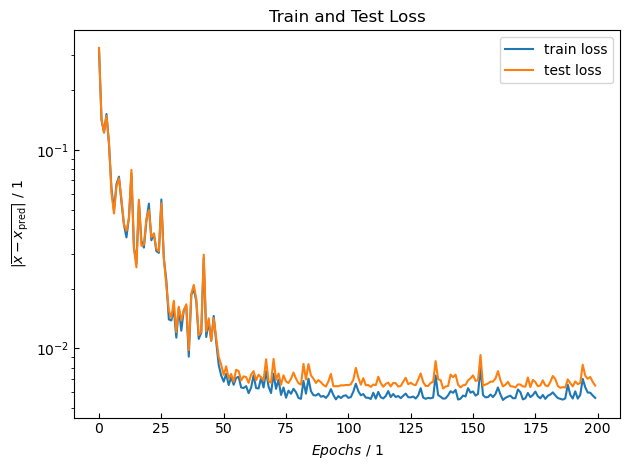

In [10]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.semilogy(train_loss, label='train loss')
ax.semilogy(test_loss, label='test loss')
plt.title("Train and Test Loss")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '|$\overline{x - x\mathregular{_{pred}}}$| / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Parity Plot

Training Dataset: R^2(H2) = 0.9760625169856278 , R^2(NH3) = 0.9688866749388833
Test Dataset: R^2(H2) = 0.985417276408346 , R^2(NH3) = 0.9715053378142133
Max Error Training: |x_H2 - x_H2,pred| = 0.1438009076738379 , |x_NH3 - x_NH3,pred| = 0.09003103668090928
Max Error Test: |x_H2 - x_H2,pred| = 0.09344269677884737 , |x_NH3 - x_NH3,pred| = 0.07036318777821746


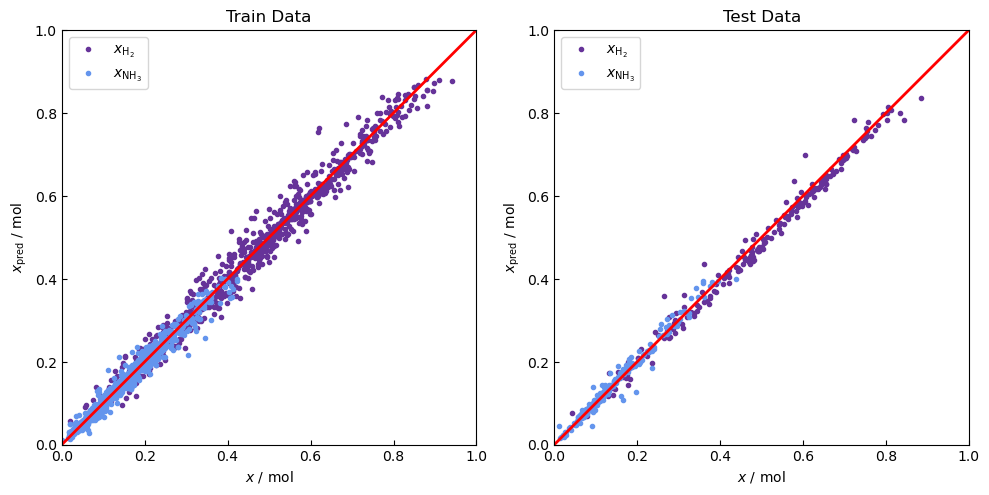

In [11]:
x_H2_real = []
x_H2_pred = []
x_NH3_real = []
x_NH3_pred = []
for (X,y) in train_dataloader:
    x_H2_real = np.append(x_H2_real, y[:,0].numpy())
    x_NH3_real = np.append(x_NH3_real, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred = np.append(x_H2_pred, help_x_H2)
    x_NH3_pred = np.append(x_NH3_pred, help_x_NH3)

x_H2_real_test = []
x_H2_pred_test = []
x_NH3_real_test = []
x_NH3_pred_test = []
for (X,y) in test_dataloader:
    x_H2_real_test = np.append(x_H2_real_test, y[:,0].numpy())
    x_NH3_real_test = np.append(x_NH3_real_test, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_test = np.append(x_H2_pred_test, help_x_H2)
    x_NH3_pred_test = np.append(x_NH3_pred_test, help_x_NH3)

print('Training Dataset: R^2(H2) =', r2(x_H2_real,x_H2_pred), ', R^2(NH3) =', r2(x_NH3_real,x_NH3_pred))
print('Test Dataset: R^2(H2) =', r2(x_H2_real_test,x_H2_pred_test), ', R^2(NH3) =', r2(x_NH3_real_test,x_NH3_pred_test))
print('Max Error Training: |x_H2 - x_H2,pred| =', max_error(x_H2_real, x_H2_pred), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real, x_NH3_pred))
print('Max Error Test: |x_H2 - x_H2,pred| =', max_error(x_H2_real_test, x_H2_pred_test), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real_test, x_NH3_pred_test))

# find the boundaries of X and Y values
bounds = (0,1)

fig,ax = plt.subplots(1,2, figsize =(10,10))

# # Reset the limits
# ax[0] = plt.gca()
ax[0].set_xlim(bounds)
ax[0].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[0].set_aspect("equal", adjustable="box")

ax[0].plot(x_H2_real, x_H2_pred, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[0].plot(x_NH3_real, x_NH3_pred, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[0].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[0].transAxes)
ax[0].set(xlabel = '$x$ / mol', ylabel = '$x\mathregular{_{pred}}$ / mol')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].set_title('Train Data')
ax[0].legend()
#ax[0].legend(['$\\mathregular{R^2}$ = ', r2(xi_real,xi_pred)], markerscale=0)

# Reset the limits
#ax[1] = plt.gca()
ax[1].set_xlim(bounds)
ax[1].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[1].set_aspect("equal", adjustable="box")

ax[1].plot(x_H2_real_test, x_H2_pred_test, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[1].plot(x_NH3_real_test, x_NH3_pred_test, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[1].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[1].transAxes)
ax[1].set(xlabel = '$x$ / mol', ylabel = '$x\mathregular{_{pred}}$ / mol')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].set_title('Test Data')
ax[1].legend()


#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

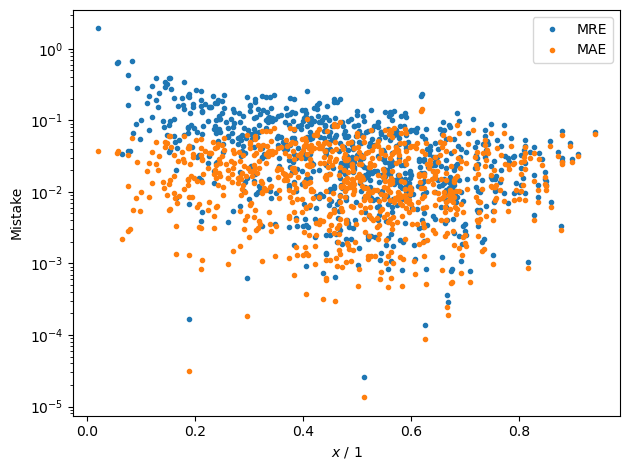

In [15]:
fig,ax = plt.subplots()
ax.semilogy(x_H2_real, abs((x_H2_pred - x_H2_real) / x_H2_real), '.', label = 'MRE')
ax.semilogy(x_H2_real, abs(x_H2_real-x_H2_pred), '.', label = 'MAE')
ax.set(xlabel = '$x$ / 1', ylabel = 'Mistake')
plt.legend()
plt.tight_layout()
plt.show()

#### Plot Fehler vs Epoch

In [ ]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.semilogy(train_MRE, label='train MRE')
ax.semilogy(test_MRE, label='test MRE')
plt.title("Mean Relative Error")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$MRE$ / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Plot Loss vs Variable Properties

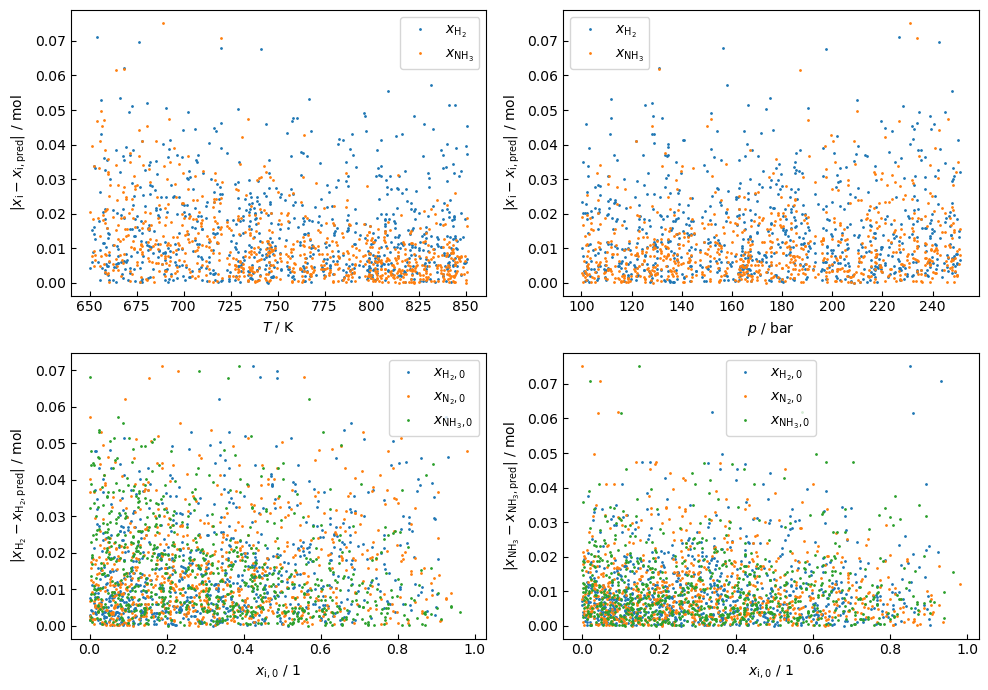

In [17]:
mistake_H2 = []
mistake_NH3 = []
param_T = []
param_p = []
param_x_H2_0 = []
param_x_N2_0 = []
param_x_NH3_0 = []
for X,y in train_dataloader:
    help_mistake_H2, help_mistake_NH3 = (abs(y - net(X).detach().numpy())).T
    mistake_H2 = np.append(mistake_H2, help_mistake_H2)
    mistake_NH3 = np.append(mistake_NH3, help_mistake_NH3)
    param_T = np.append(param_T, X[:,0])
    param_p = np.append(param_p, X[:,1])
    param_x_H2_0 = np.append(param_x_H2_0, X[:,2])
    param_x_N2_0 = np.append(param_x_N2_0, X[:,3])
    param_x_NH3_0 = np.append(param_x_NH3_0, X[:,4])

# train_parameters, train_xi = next(iter(train_dataloader))
# y = abs(train_xi - net(train_parameters).detach().numpy())
# #[T, p ,x_H2, x_N2, x_NH3]
# x = [train_parameters[:,0], train_parameters[:,1], train_parameters[:,2], train_parameters[:,3], train_parameters[:,4]]

# print(param_T[0])
# print(param_T)
# print(mistake)

fig,ax = plt.subplots(2,2, figsize = (10, 7)) #gridspec_kw={'width_ratios': [1,1,1,1]})

ax[0,0].plot(param_T, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,0].plot(param_T, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,0].set(xlabel = '$T$ / K', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,0].legend()

ax[0,1].plot(param_p, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,1].plot(param_p, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,1].set(xlabel = '$p$ / bar', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,1].legend()

ax[1,0].plot(param_x_H2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,0].plot(param_x_N2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,0].plot(param_x_NH3_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,0].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{H_2}} - x\mathregular{_{H_2,pred}}$| / mol')
ax[1,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,0].legend()

ax[1,1].plot(param_x_H2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,1].plot(param_x_N2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,1].plot(param_x_NH3_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,1].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{NH_3}} - x\mathregular{_{NH_3,pred}}$| / mol')
ax[1,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,1].legend()

plt.tight_layout()
plt.show()

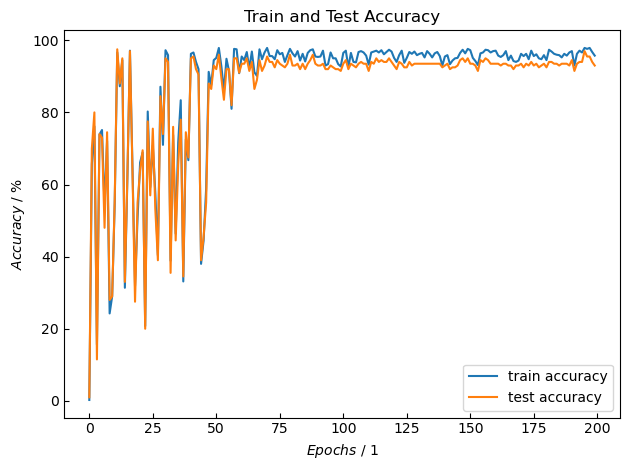

In [16]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_accuracy, label='train accuracy')
ax.plot(test_accuracy, label='test accuracy')
plt.title("Train and Test Accuracy")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$Accuracy$ / %') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Debugging Hilfe

In [ ]:
# Anzeigen aller Input X und Output y Daten
for (X,y) in train_dataloader:
    print(X)
    print(y)
    print(net(X))
    break

#### Einblick in Netzwerk

In [ ]:
list(net.parameters()) # zeigt weights, biases, ...

In [ ]:
X = torch.rand((2,5))
print(X)
print(net(X))

In [ ]:
Lnorm = nn.LayerNorm(5)
Bnorm = nn.BatchNorm1d(5)

In [ ]:
for (X,y) in train_dataloader:
    print(X)
    #print(y.reshape((-1,1)))
    print(Bnorm(X).mean(dim=0))
    print(Bnorm(X))
    print(Lnorm(X))
    print((Lnorm(X.permute(0,2,1))).permute(0,2,1))
    print(Lnorm(X).mean(dim=0))
    print(Lnorm(X).mean(dim=1))


    break

#### Histogramme Verteilung von $xi$ und $x{_i}$

In [ ]:
#plt.hist(xi)
plt.hist(x_0[:,0],bins=100)
plt.hist(x_0[:,1],bins=100)

plt.show()